In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from torch.utils.data import Dataset, DataLoader

In [3]:
from tokenizers import Tokenizer
from tokenizers import ByteLevelBPETokenizer
from tokenizers.pre_tokenizers import Whitespace

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

In [4]:
import numpy as np
import pandas as pd

### data

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### tokenizer: train

In [6]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.pre_tokenizer = Whitespace()
tokenizer.enable_padding(pad_id=0, pad_token='<pad>')

In [7]:
texts_path = 'texts.txt'

with open(texts_path, 'w') as f:
    for text in list(train['text'].values):
        f.write("%s\n" % text)

In [8]:
tokenizer.train(
    files=[texts_path],
    vocab_size=5_000,
    min_frequency=2,
    special_tokens=['<pad>', '<unk>']
    )

### load BERT tokenizer

In [9]:
tokenizer_bert = BertTokenizer.from_pretrained('./rubert-tiny')

### dataset

In [10]:
class CustomDataset(Dataset):

    def __init__(self, tokens, labels, max_len):
        self.tokens = tokens
        self.labels = labels
        self.max_len = max_len


    def __len__(self):
        return len(self.tokens)


    def __getitem__(self, idx):
        label = self.labels[idx]
        label = torch.tensor(label)
        tokens = self.tokens[idx]
        out = torch.zeros(self.max_len, dtype=torch.long)
        out[:len(tokens)] = torch.tensor(tokens, dtype=torch.long)[:self.max_len]
        return out, label

In [11]:
max_len = 64
BATCH_SIZE = 16

In [12]:
train_labels = list(train['label'])
train_tokens = [tokenizer.encode(str(text)).ids for text in list(train['text'])]
train_dataset = CustomDataset(train_tokens, train_labels, max_len)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
test_labels = list(test['label'])
test_tokens = [tokenizer.encode(str(text)).ids for text in list(test['text'])]
test_dataset = CustomDataset(test_tokens, test_labels, max_len)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
class LSTM_classifier(nn.Module):


    def __init__(self, hidden_dim=128, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.3, n_classes=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
        out = torch.squeeze(out, 1)
        out = torch.sigmoid(out)
        return out

In [ ]:
########

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [ ]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='binary')
    return score

In [ ]:
def train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=20):
    best_score = 0
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            loss = loss_function(predict, labels)
            loss.backward()
            optimizer.step()
        score = eval_nn(model, test_loader)
        print(epoch, 'valid:', score)
        if score > best_score:
            torch.save(model.state_dict(), 'lstm.pt')
            best_score = score
    return best_score

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = LSTM_classifier(hidden_dim=256, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.1)   

In [ ]:
model.apply(init_weights);

In [ ]:
model.to(device);

In [ ]:
optimizer = optim.AdamW(model.parameters())

In [ ]:
loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
train_nn(model, optimizer, loss_function, train_loader, test_loader, device, epochs=3)

In [ ]:
#####

In [58]:
class DistillDataset(Dataset):

    def __init__(self, texts, labels, tokenizer_bert, tokenizer_lstm, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer_bert = tokenizer_bert
        self.tokenizer_lstm = tokenizer_lstm
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)


    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        label = torch.tensor(label)
        # lstm
        tokens_lstm = self.tokenizer_lstm.encode(str(text)).ids
        out_lstm = torch.zeros(self.max_len, dtype=torch.long)
        out_lstm[:len(tokens_lstm)] = torch.tensor(tokens_lstm, dtype=torch.long)[:self.max_len]
        # bert
        encoding = self.tokenizer_bert.encode_plus(
            str(text),
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out_bert = {
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
        }
        return out_lstm, out_bert, label

In [59]:
train_dataset_distill = DistillDataset(
    list(train['text']),
    list(train['label']),
    tokenizer_bert,
    tokenizer,
    max_len
)

In [60]:
train_loader_distill = DataLoader(train_dataset_distill, batch_size=BATCH_SIZE, shuffle=True)

### BERT-teacher model

In [61]:
class BertTrainer:

    def __init__(self, path_model, n_classes=2):
        self.model = BertForSequenceClassification.from_pretrained(path_model, num_labels=n_classes)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.model.to(self.device)
        self.model = self.model.eval()
    
    def predict(self, inputs):     
        input_ids = inputs["input_ids"].to(self.device)
        attention_mask = inputs["attention_mask"].to(self.device)
        with torch.no_grad():
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        return outputs.logits

In [62]:
teacher = BertTrainer('./rubert-tiny')

Some weights of the model checkpoint at ./rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized 

### BiLSTM-student model

In [86]:
class CustomLSTM(nn.Module):


    def __init__(self, hidden_dim=128, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.3, n_classes=2):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.lstm_layer = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout_layer = nn.Dropout(dropout)        
        self.fc_layer = nn.Linear(hidden_dim * 2, linear_dim)
        self.batchnorm = nn.BatchNorm1d(linear_dim)
        self.relu = nn.ReLU()
        self.out_layer = nn.Linear(linear_dim, n_classes)


    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeddings = self.embedding_layer(inputs)
        lstm_out, (ht, ct) = self.lstm_layer(embeddings)
        out = ht.transpose(0, 1)
        out = out.reshape(batch_size, -1)
        out = self.fc_layer(out)
        out = self.batchnorm(out)
        out = self.relu(out)
        out = self.dropout_layer(out)
        out = self.out_layer(out)
#         out = torch.squeeze(out, 1)
#         out = torch.sigmoid(out)
        return out

In [87]:
def loss_function(output, teacher_prob, real_label, a=0.5):
    criterion_mse = torch.nn.MSELoss()
    criterion_ce = torch.nn.CrossEntropyLoss()
    return a * criterion_ce(output, real_label) + (1 - a) * criterion_mse(output, teacher_prob)

In [88]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [89]:
def eval_nn(model, data_loader):
    predicted = []
    labels = []
    model.eval()
    with torch.no_grad():
        for data in data_loader:
            x, y = data
            x = x.to(device)
            outputs = model(x)
            _, predict = torch.max(outputs.data, 1)
            predict = predict.cpu().detach().numpy().tolist()
            predicted += predict
            labels += y
        score = f1_score(labels, predicted, average='binary')
    return labels, predicted, score

In [90]:
def train_distill(model, teacher, optimizer, loss_function, distill_loader, train_loader, test_loader, device, epochs=30, alpha=0.5):
    best_score = 0
    score_list = []
    for epoch in range(epochs):
        model.train()
        for inputs, inputs_teacher, labels in distill_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            predict = model(inputs)
            teacher_predict = teacher.predict(inputs_teacher)
            loss = loss_function(predict, teacher_predict, labels, alpha)
            loss.backward()
            optimizer.step()
        score_train = round(eval_nn(model, train_loader)[2], 3)
        score_test = round(eval_nn(model, test_loader)[2], 3)
        score_list.append((score_train, score_test))
        print(epoch, score_train, score_test)
        if score_test > best_score:     
            best_score = score_test
            best_model = model
    torch.save(best_model.state_dict(), f'./results/lstm_{best_score}.pt')
    return best_model, best_score, score_list

In [91]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [92]:
vocab_size = tokenizer.get_vocab_size()

In [93]:
vocab_size

5000

In [94]:
score_alpha = []
for alpha in [0, 0.25, 0.5, 0.75, 1]:
    model = LSTM_classifier(hidden_dim=256, vocab_size=5000, embedding_dim=300, linear_dim=128, dropout=0.1)   

    model.apply(init_weights)
    model.to(device)
    optimizer = optim.AdamW(model.parameters())
    _, _, score_list = train_distill(model, teacher, optimizer, loss_function, train_loader_distill, train_loader, test_loader, device, 30, alpha)
    score_alpha.append(score_list)

0 0.318 0.324
1 0.345 0.363
2 0.359 0.367
3 0.275 0.298
4 0.235 0.232
5 0.217 0.23
6 0.244 0.24
7 0.251 0.259
8 0.23 0.206
9 0.228 0.222
10 0.2 0.18
11 0.209 0.184
12 0.235 0.214
13 0.242 0.216
14 0.233 0.207
15 0.239 0.205
16 0.242 0.201
17 0.25 0.232
18 0.25 0.22
19 0.246 0.221
20 0.241 0.222
21 0.254 0.244
22 0.235 0.219
23 0.238 0.218
24 0.237 0.208
25 0.251 0.234
26 0.253 0.244
27 0.24 0.223
28 0.243 0.226
29 0.239 0.218
0 0.615 0.553
1 0.817 0.724
2 0.829 0.713
3 0.912 0.782
4 0.948 0.816
5 0.961 0.808
6 0.961 0.807
7 0.967 0.803
8 0.972 0.789
9 0.978 0.807
10 0.984 0.809
11 0.976 0.779
12 0.987 0.803
13 0.988 0.803
14 0.99 0.811
15 0.989 0.791
16 0.986 0.787
17 0.993 0.796
18 0.994 0.797
19 0.993 0.805
20 0.993 0.81
21 0.995 0.81
22 0.993 0.797
23 0.991 0.8
24 0.994 0.795
25 0.994 0.794
26 0.994 0.803
27 0.995 0.819
28 0.995 0.811
29 0.993 0.804
0 0.769 0.715
1 0.863 0.746
2 0.904 0.755
3 0.94 0.792
4 0.973 0.798
5 0.981 0.792
6 0.983 0.79
7 0.989 0.789
8 0.989 0.796
9 0.988 0.7

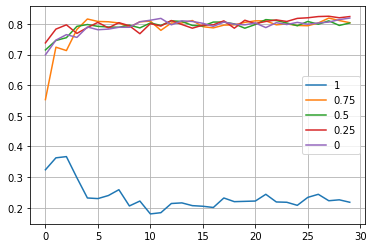

In [95]:
import matplotlib.pyplot as plt
import numpy as np

a_list = [1, 0.75, 0.5, 0.25, 0]

for i, score in enumerate(score_alpha):
    _, score_test = list(zip(*score))
    plt.plot(score_test, label=f'{a_list[i]}')
plt.grid(True)
plt.legend()
plt.show()